<a href="https://colab.research.google.com/github/abhinavreddy910/RL_project/blob/main/Original_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import gym
import matplotlib.pyplot as plt
from matplotlib import style
from  matplotlib import pylab
from google.colab import drive
from skimage.color import rgb2gray
from collections import deque
from keras.models import Sequential
from keras.layers import Conv2D,Dense, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
%matplotlib inline

In [ ]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,9)
load_model = False 

In [ ]:
%%capture
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def preprocess_img(img):
    # Crop and resize the image
    img = img[1:168:2,::2]

    # Convert the image to greyscale
    #img = img.mean(axis=2)
    #img = tf.image.rgb_to_grayscale(img)
    img = rgb2gray(img)

    # reshaping
    img = img.reshape(84,80,1)

    return img

Discrete(9)
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
Box(0, 255, (210, 160, 3), uint8)

Action Size = 9
State Size = 210



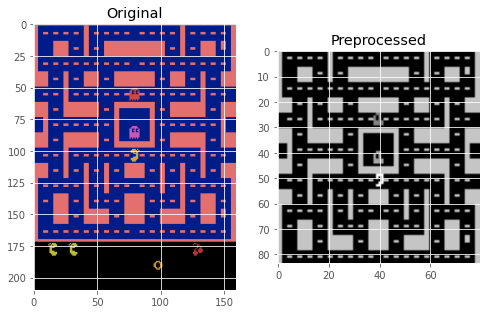

In [ ]:
env = gym.make("MsPacman-v0")
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

print(env.action_space)
print(env.get_action_meanings())
print(env.observation_space)
print("\nAction Size = " + str(action_size))
print("State Size = " + str(state_size) + "\n")

observation = env.reset()

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].imshow(observation)
ax[0].set_title("Original")
ax[1].imshow(preprocess_img(observation).reshape(84,80), cmap=plt.cm.gray)
#ax[1].imshow(preprocess_img(observation), cmap=plt.cm.gray)
ax[1].set_title("Preprocessed")
plt.show()

In [ ]:
num_episodes= 150     

replay_memory_size = 1000  
training_threshold = 200

update_target_every = 3

epsilon_final_episode = 20                
epsilon_min = 0.1     

gamma = 0.99
learning_rate = 0.00025        
batch_size = 32 

load_model = False  

In [ ]:
class Agent():
    def __init__(self, epsilon_final_episode, epsilon_min, 
                       gamma, learning_rate, state_size, action_size,
                       batch_size, replay_memory_size,training_threshold):
        '''CREATING AND DEFINING BASIC PARAMETERS FOR TRAINING'''
        # Change epsilon if model is already trained.
        self.epsilon = 1.0                                                                
        self.epsilon_final_episode = epsilon_final_episode 
        self.epsilon_min = epsilon_min                
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.replay_memory_size = replay_memory_size

        self.state_size = state_size
        self.action_size = action_size
        
        self.batch_size = batch_size
        self.training_threshold = training_threshold

         # Main Model
        self.model = self.create_model()
        
         # Target Model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
 
        self.target_update_counter = 0

        # Replay Memory
        self.replay_memory = deque(maxlen=self.replay_memory_size) 

        if load_model:
            self.model.load_weights("/content/drive/MyDrive/Colab Notebooks/RL_Project/Checkpoints/weights2.h5")        
        
    def update_replay_memory(self, state, action, reward, next_state, done):
        '''UPDATING REPLAY MEMORY and DECAYING EPSILON'''
        self.replay_memory.append((state, action, reward, next_state, done))

    def update_epsilon(self,episode):
        if episode <= self.epsilon_final_episode:                                                       
            self.epsilon = 1 + ((self.epsilon_min - 1)/self.epsilon_final_episode)*episode   # Linearly annealed  
    

    def create_model(self):
        '''CREATING NEURAL NETWORK'''
        keras.backend.clear_session()
        model = Sequential()
        model.add(Conv2D(16,kernel_size = (8,8),strides = 4,padding='same',activation='relu',input_shape=(84,80,1)))
        model.add(Conv2D(32,kernel_size = (4,4),strides = 2,padding='same',activation='relu'))
        model.add(Flatten())
        model.add(Dense(256, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.summary()
        model.compile(optimizer=RMSprop(learning_rate==self.learning_rate), loss = "mse")          
        return model
    

    def select_action(self, state):
        '''DEFINING EPSILON GREEDY STRATEGY'''
        if np.random.rand() > self.epsilon:
            q_value = self.model.predict(state.reshape(1,84,80,1),batch_size=1)
            return np.argmax(q_value[0])
        else:
            return np.random.randint(0, self.action_size)             
 

    def train_agent(self):
        '''TRAINING AGENT'''
        if len(self.replay_memory) < self.training_threshold:
                  return
        
        batch_size = min(self.batch_size, len(self.replay_memory))
        minibatch = random.sample(self.replay_memory, batch_size)
 
        observations = np.zeros((batch_size, 84, 80, 1))                    
        next_observations = np.zeros((batch_size, 84, 80, 1))
        
        action = []
        reward = [] 
        done = []
        
        for sample_index in range(self.batch_size):
            observations[sample_index] = minibatch[sample_index][0]                       
            action.append(minibatch[sample_index][1])
            reward.append(minibatch[sample_index][2])
            next_observations[sample_index] = minibatch[sample_index][3]
            done.append(minibatch[sample_index][4])

            
        current_q_values = self.model.predict(observations)
        future_q_values = self.target_model.predict(next_observations)
    
        for index in range(self.batch_size):
            if not done[index]:    
                current_q_values[index][action[index]] = reward[index] + self.gamma * (np.amax(future_q_values[index]))
            else:
                current_q_values[index][action[index]] = reward[index]            

        self.model.fit(observations, current_q_values, batch_size = batch_size, verbose=0)                              
        
        if done:
            self.target_update_counter += 1
        
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 20, 16)        1040      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 10, 32)        8224      
                                                                 
 flatten (Flatten)           (None, 3520)              0         
                                                                 
 dense (Dense)               (None, 256)               901376    
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 912,953
Trainable params: 912,953
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
______________________________

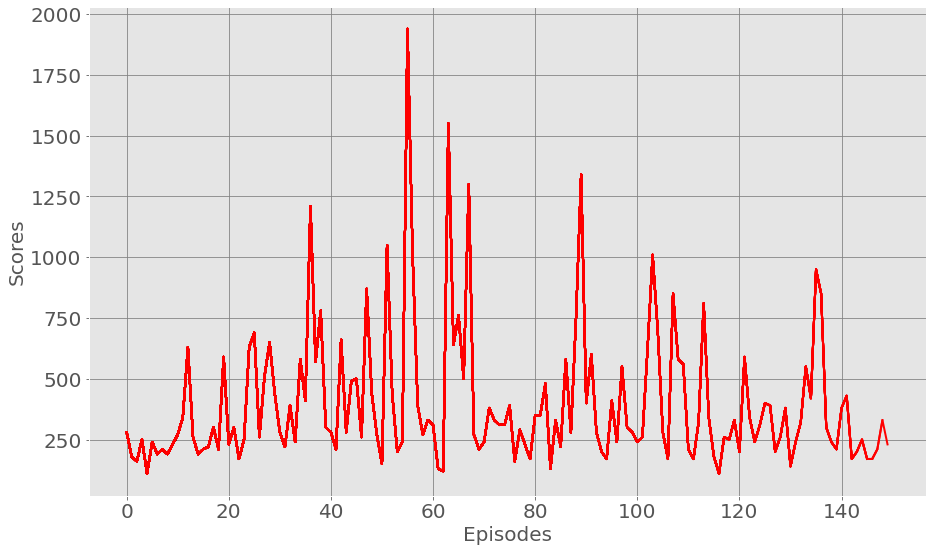

In [ ]:
agent = Agent(epsilon_final_episode, epsilon_min, 
                  gamma, learning_rate, state_size, 
                  action_size, batch_size, replay_memory_size,training_threshold)

scores = []
eps_plot = []
episodes = []
rewards_lst = []

for episode in range(num_episodes):
    done = False
    score = 0
    frame = 0
    state = env.reset()
    #state = np.reshape(state, [1, 100800])
    state = preprocess_img(state)  
    agent.update_epsilon(episode)                                    
    while not done:
            #env.render()
            action = agent.select_action(state)
                
            next_state, reward, done, info = env.step(action)                      
            #next_state = np.reshape(next_state, [1, 100800])  
            next_state = preprocess_img(next_state)                  
                
            agent.update_replay_memory(state, action, reward, next_state, done)
            agent.train_agent()
                
            state = next_state
            score += reward
            frame += 1
   
    scores.append(score)
    episodes.append(episode)
    print("Episode:", episode, "     Score:", score,"     Epsilon:", agent.epsilon,"     Frames:", frame)

    if (episode % 5 == 0) & (load_model==False):
        agent.model.save_weights("/content/drive/MyDrive/Colab Notebooks/RL_Project/Checkpoints/weights2.h5")
        print("Saved model to disk")
    
    pylab.plot(episodes, scores, 'red', linewidth=2)
    plt.xlabel("Episodes",size=20)
    plt.ylabel("Scores",size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.grid(True,color="gray")
    pylab.savefig("/content/drive/MyDrive/Colab Notebooks/RL_Project/Scores2.png")